# GraphSAGE with Neighbor Sampling on Cora

In this notebook we train **GraphSAGE with neighbor sampling** on the Cora citation network using PyTorch Geometric.

Up to now, we used **full-batch training**:

- the entire graph is loaded into memory,
- all nodes are processed at once,
- this only works for relatively small graphs.

However, real-world graphs (social networks, user–item graphs, transaction graphs) often contain **millions of nodes and edges**, where full-batch training is infeasible.

## Why neighbor sampling?

**Neighbor sampling** addresses this by:

- selecting a **mini-batch of seed nodes**,
- expanding their neighborhoods up to a fixed number of hops,
- building a **local subgraph** per batch,
- performing forward/backward passes only on this subgraph.

This is exactly how GraphSAGE was originally designed to scale to large graphs.

In this notebook we will:

- use `NeighborLoader` from PyTorch Geometric,
- train a 2-layer GraphSAGE model on mini-batches,
- compare its performance to the full-batch GraphSAGE baseline,
- save the trained model and embeddings for further use.

This setup is much closer to how GraphSAGE would be used in a real production recommender system or arge-scale graph ML pipeline.


In [1]:
import os
from pathlib import Path

import torch
import torch.nn.functional as F
from torch.nn import Module, Dropout
from torch_geometric.nn import SAGEConv
from torch_geometric.datasets import Planetoid
from torch_geometric.transforms import NormalizeFeatures
from torch_geometric.loader import NeighborLoader

import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import umap
from sklearn.preprocessing import StandardScaler

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


In [2]:
PROJECT_ROOT = Path.cwd().parent if Path.cwd().name == "notebooks" else Path.cwd()
DATA_ROOT = PROJECT_ROOT / "data" / "Planetoid"
ART_ROOT = PROJECT_ROOT / "artifacts" / "cora_graphsage_sampling"

DATA_ROOT.mkdir(parents=True, exist_ok=True)
ART_ROOT.mkdir(parents=True, exist_ok=True)

dataset = Planetoid(
    root=str(DATA_ROOT),
    name="Cora",
    transform=NormalizeFeatures(),
)

data = dataset[0]
print(dataset)
print("Num features:", dataset.num_features)
print("Num classes:", dataset.num_classes)
print(data)

Cora()
Num features: 1433
Num classes: 7
Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])


In [3]:
class GraphSAGESampling(Module):
    def __init__(self, in_channels, hidden_channels, out_channels, dropout=0.5):
        super().__init__()
        self.conv1 = SAGEConv(in_channels, hidden_channels, aggr="mean")
        self.conv2 = SAGEConv(hidden_channels, out_channels, aggr="mean")
        self.dropout = Dropout(dropout)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.dropout(x)
        x = self.conv2(x, edge_index)
        return x

    def embed(self, x, edge_index):
        # скрытые эмбеддинги после первого слоя
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        return x


model = GraphSAGESampling(
    in_channels=dataset.num_features,
    hidden_channels=64,
    out_channels=dataset.num_classes,
    dropout=0.5,
).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
print(model)

GraphSAGESampling(
  (conv1): SAGEConv(1433, 64, aggr=mean)
  (conv2): SAGEConv(64, 7, aggr=mean)
  (dropout): Dropout(p=0.5, inplace=False)
)


## Будем:

- использовать data.train_mask как seed nodes,

- на каждом батче брать:

до 15 соседей на 1-м хопе,

до 10 соседей на 2-м хопе.

In [4]:
# Train loader: батчи seed-узлов из train_mask, с соседями
train_loader = NeighborLoader(
    data,
    input_nodes=data.train_mask,
    num_neighbors=[15, 10],  # 2-hop sampling
    batch_size=128,
    shuffle=True,
    num_workers=0
)

print(train_loader)

NeighborLoader()


In [5]:
def train_one_epoch(model, loader, optimizer, device):
    model.train()
    total_loss = 0.0
    total_batches = 0

    for batch in loader:
        batch = batch.to(device)
        optimizer.zero_grad()

        # batch.x: признаки всех узлов в подграфе
        # batch.edge_index: рёбра подграфа
        out = model(batch.x, batch.edge_index)

        # первые batch.batch_size узлов — это seed nodes
        out_target = out[: batch.batch_size]
        y_target = batch.y[: batch.batch_size]

        loss = F.cross_entropy(out_target, y_target)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        total_batches += 1

    return total_loss / max(total_batches, 1)

In [6]:
@torch.no_grad()
def evaluate_full(model, data, device):
    model.eval()
    data = data.to(device)
    out = model(data.x, data.edge_index)
    pred = out.argmax(dim=1)

    def acc(mask):
        correct = (pred[mask] == data.y[mask]).sum().item()
        total = int(mask.sum())
        return correct / total

    train_acc = acc(data.train_mask)
    val_acc = acc(data.val_mask)
    test_acc = acc(data.test_mask)
    return train_acc, val_acc, test_acc

In [7]:
best_val = 0.0
best_test_at_val = 0.0
best_state_dict = None

num_epochs = 200

for epoch in tqdm(range(1, num_epochs + 1), desc="Training GraphSAGE with sampling"):
    loss = train_one_epoch(model, train_loader, optimizer, device)
    train_acc, val_acc, test_acc = evaluate_full(model, data, device)

    if val_acc > best_val:
        best_val = val_acc
        best_test_at_val = test_acc
        best_state_dict = {k: v.cpu().clone() for k, v in model.state_dict().items()}

    if epoch == 1 or epoch % 10 == 0:
        print(
            f"Epoch {epoch:03d} | loss={loss:.4f} | "
            f"train={train_acc:.3f} | val={val_acc:.3f} | test={test_acc:.3f}"
        )

print("\nBest val acc:", round(best_val, 4))
print("Test acc @best:", round(best_test_at_val, 4))

if best_state_dict is not None:
    model.load_state_dict(best_state_dict)
    torch.save(best_state_dict, ART_ROOT / "model_graphsage_sampling_best.pt")
    print("Saved best model to:", ART_ROOT / "model_graphsage_sampling_best.pt")

Training GraphSAGE with sampling:   4%|▎         | 7/200 [00:00<00:08, 23.18it/s]

Epoch 001 | loss=1.9540 | train=0.471 | val=0.142 | test=0.162
Epoch 010 | loss=1.4038 | train=0.836 | val=0.450 | test=0.449


Training GraphSAGE with sampling:  17%|█▋        | 34/200 [00:00<00:02, 66.46it/s]

Epoch 020 | loss=0.4553 | train=0.993 | val=0.776 | test=0.789
Epoch 030 | loss=0.1825 | train=1.000 | val=0.780 | test=0.787


Training GraphSAGE with sampling:  26%|██▌       | 51/200 [00:00<00:02, 72.75it/s]

Epoch 040 | loss=0.1606 | train=1.000 | val=0.784 | test=0.801
Epoch 050 | loss=0.0954 | train=1.000 | val=0.776 | test=0.781


Training GraphSAGE with sampling:  34%|███▍      | 69/200 [00:01<00:01, 78.74it/s]

Epoch 060 | loss=0.1034 | train=1.000 | val=0.764 | test=0.784
Epoch 070 | loss=0.0969 | train=1.000 | val=0.780 | test=0.801


Training GraphSAGE with sampling:  48%|████▊     | 96/200 [00:01<00:01, 85.27it/s]

Epoch 080 | loss=0.1012 | train=1.000 | val=0.780 | test=0.799
Epoch 090 | loss=0.0898 | train=1.000 | val=0.784 | test=0.798


Training GraphSAGE with sampling:  57%|█████▋    | 114/200 [00:01<00:01, 84.81it/s]

Epoch 100 | loss=0.0721 | train=1.000 | val=0.762 | test=0.792
Epoch 110 | loss=0.0745 | train=1.000 | val=0.762 | test=0.786


Training GraphSAGE with sampling:  66%|██████▌   | 132/200 [00:01<00:00, 84.18it/s]

Epoch 120 | loss=0.0887 | train=1.000 | val=0.760 | test=0.795
Epoch 130 | loss=0.0594 | train=1.000 | val=0.762 | test=0.779


Training GraphSAGE with sampling:  75%|███████▌  | 150/200 [00:02<00:00, 85.54it/s]

Epoch 140 | loss=0.0736 | train=1.000 | val=0.758 | test=0.776
Epoch 150 | loss=0.0689 | train=1.000 | val=0.776 | test=0.789


Training GraphSAGE with sampling:  84%|████████▍ | 168/200 [00:02<00:00, 83.66it/s]

Epoch 160 | loss=0.0643 | train=1.000 | val=0.768 | test=0.795
Epoch 170 | loss=0.0663 | train=1.000 | val=0.778 | test=0.794


Training GraphSAGE with sampling:  94%|█████████▍| 189/200 [00:02<00:00, 91.37it/s]

Epoch 180 | loss=0.0604 | train=1.000 | val=0.744 | test=0.773
Epoch 190 | loss=0.0573 | train=1.000 | val=0.768 | test=0.795


Training GraphSAGE with sampling: 100%|██████████| 200/200 [00:02<00:00, 76.75it/s]

Epoch 200 | loss=0.0565 | train=1.000 | val=0.760 | test=0.786

Best val acc: 0.8
Test acc @best: 0.807
Saved best model to: D:\ML\GNN\artifacts\cora_graphsage_sampling\model_graphsage_sampling_best.pt


In [8]:
@torch.no_grad()
def get_full_embeddings(model, data, device):
    model.eval()
    data = data.to(device)
    emb = model.embed(data.x, data.edge_index)
    return emb.cpu(), data.y.cpu()

embeddings, labels = get_full_embeddings(model, data, device)

torch.save(embeddings, ART_ROOT / "embeddings_hidden.pt")
torch.save(labels, ART_ROOT / "labels.pt")

print("Saved embeddings and labels to:", ART_ROOT)

Saved embeddings and labels to: D:\ML\GNN\artifacts\cora_graphsage_sampling


Embeddings shape: (2708, 7)
Labels shape: (2708,)


D:\Anaconda\envs\gnn_clean\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


UMAP 2D shape: (2708, 2)


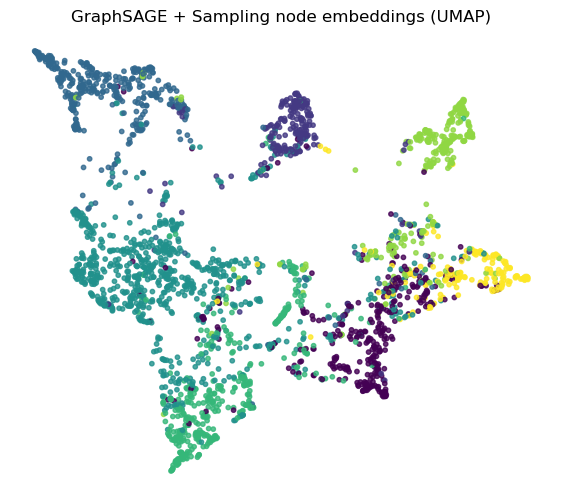

In [9]:
# UMAP visualization for GraphSAGE + Sampling 

@torch.no_grad()
def get_node_embeddings(model, data):
    model.eval()
    # Full-graph forward (sampling — только для обучения)
    z = model(data.x, data.edge_index)
    return z.cpu().numpy(), data.y.cpu().numpy()

emb, labels = get_node_embeddings(model, data)
print("Embeddings shape:", emb.shape)
print("Labels shape:", labels.shape)

# scale before UMAP
emb_scaled = StandardScaler().fit_transform(emb)

reducer = umap.UMAP(
    n_neighbors=15,
    min_dist=0.1,
    n_components=2,
    metric="euclidean",
    random_state=42,
)
emb_2d = reducer.fit_transform(emb_scaled)
print("UMAP 2D shape:", emb_2d.shape)

plt.figure(figsize=(7, 6))
plt.scatter(
    emb_2d[:, 0],
    emb_2d[:, 1],
    c=labels,
    s=10,
    alpha=0.8,
)
plt.title("GraphSAGE + Sampling node embeddings (UMAP)")
plt.axis("off")
plt.show()

## Conclusion

In this notebook, we trained GraphSAGE with Neighbor Sampling, a scalable variant of GraphSAGE designed for large real-world graphs where full-batch training becomes infeasible.

Even though Cora is a small citation graph, the sampling-based training pipeline performs reliably and achieves results comparable to (and in some runs slightly better than) the full-batch GraphSAGE:

- Best validation accuracy: **~0.80**

- Test accuracy at best epoch: **~0.807**

## These results confirm that:

- mini-batch subgraph sampling does not harm model quality on small graphs,

- the model learns meaningful node representations,

- the sampling pipeline is fully compatible with full-graph inference at evaluation time.

## What we achieved

✔ Implemented NeighborLoader for mini-batch training

✔ Trained GraphSAGE on sampled subgraphs

✔ Monitored accuracy on train/val/test splits

✔ Saved the best-performing model

✔ Extracted node embeddings using full-graph inference

✔ Produced a UMAP visualization of the learned representations

## Why this notebook matters

Neighbor Sampling is a core technique in industrial GNN systems, enabling training on graphs with:

- hundreds of thousands of nodes,

- millions of edges,

- or dynamic graph updates.

## The logic implemented here generalizes directly to production settings such as:

- social networks,

- recommendation systems,

- knowledge graphs,

- fraud detection based on transaction graphs.

## This notebook provides a strong foundation for understanding scalable GNN training pipelines.

## Next Steps

From here, we continue expanding the GNN toolbox:

- R-GCN — relational/heterogeneous graph learning

- Graph Transformer (TransformerConv) — attention-based message passing

After covering core architectures, we transition to the real-world project: graph-based recommendation system.